# Main demos for datadownload 

In [3]:
#Temporary prior to pip installing the library
import sys
sys.path.append("..")
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from hrud import HRUD

In [4]:
%matplotlib inline

## Setup the library (run the constructor to get acces to some general parameters)

In [5]:
hd = HRUD()

## Downloading data for different cities and plotting

In [6]:
lima = hd.download_osm(2, 'Lima,Peru')
quito = hd.download_osm(1, 'Quito, Ecuador')
ba = hd.download_osm(0, 'Buenos Aires, Argentina')

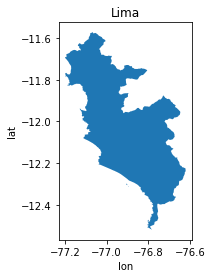

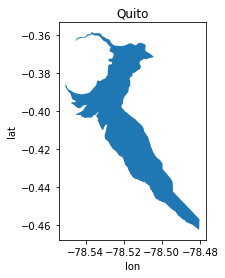

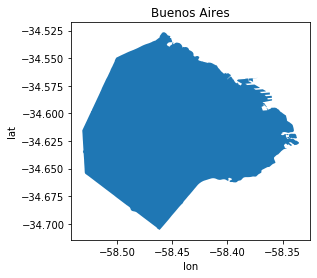

In [7]:
lima.plot()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Lima')
plt.show()

quito.plot()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Quito')
plt.show()

ba.plot()
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Buenos Aires')
plt.show()

Lima is still missing the Callao polygon, lets download it as well

In [8]:
callao = hd.download_osm(1, 'Callao, Peru')

### Downloading population data

In [9]:
pop_per = hd.download_hdx("4e74db39-87f1-4383-9255-eaf8ebceb0c9/resource/317f1c39-8417-4bde-a076-99bd37feefce/download/population_per_2018-10-01.csv.zip")
pop_ecu = hd.download_hdx('58c3ac3f-febd-4222-8969-59c0fe0e7a0d/resource/c05a3c81-a78c-4e6c-ac05-de1316d4ba12/download/population_ecu_2018-10-01.csv.zip')
pop_arg = hd.download_hdx('6cf49080-1226-4eda-8700-a0093cbdfe4d/resource/5737d87f-e17f-4c82-b1bd-d589ed631318/download/population_arg_2018-10-01.csv.zip')

In [10]:
pop_per.head()

,latitude,longitude,population_2015,population_2020
0,-18.339306,-70.382361,11.318147,12.099885
1,-18.335694,-70.393750,11.318147,12.099885
2,-18.335694,-70.387361,11.318147,12.099885
3,-18.335417,-70.394028,11.318147,12.099885
4,-18.335139,-70.394306,11.318147,12.099885


### Merging layers

In [11]:
lima = hd.merge_geom_downloads([lima, callao])

### Conversion to Point geometries and hexagons

We got the lat lon coordinates but their are just in numerical format, we need them as geometries to perform spatial operations on the hexagon grid

First, lets filter the national population to our city bounds

In [30]:
pop_lima = hd.filter_population(pop_per, lima)
pop_quito = hd.filter_population(pop_ecu, quito)
pop_ba = hd.filter_population(pop_arg, ba)

Applying filter_population gives us the set of points within our city's bounds and a Point geometry to work with hexagons

In [13]:
pop_lima.head()

,latitude,longitude,population_2015,population_2020,geometry
1301807,-12.519861,-76.774583,2.633668,2.644757,POINT (-76.77458 -12.51986)
1301808,-12.519861,-76.745972,2.633668,2.644757,POINT (-76.74597 -12.51986)
1301809,-12.519861,-76.745694,2.633668,2.644757,POINT (-76.74569 -12.51986)
1301810,-12.519861,-76.742639,2.633668,2.644757,POINT (-76.74264 -12.51986)
1301811,-12.519861,-76.741250,2.633668,2.644757,POINT (-76.74125 -12.51986)


### Removing unnecesary features

We don't need the San Lorenzo island. By providing a bounding box we an remove it

In [33]:
pop_lima = hd.remove_features(pop_lima, [-12.2,-12, -77.3,-77.17])

Let's generate the hexagon grid using Uber's H3

In [37]:
hex_lima, hex_lima_centroids = hd.gen_hexagons(8, lima)
hex_quito, hex_quito_centroids = hd.gen_hexagons(10, quito)
hex_ba, hex_ba_centroids = hd.gen_hexagons(9, ba)

Notice the effect of the resolution parameter (higher values apply generate smaller hexagons)

In [38]:
print(hex_lima.shape)
print(hex_quito.shape)
print(hex_ba.shape)

(3300, 2)
(1226, 2)
(2808, 2)


### Merging a layer

We got both the population point geometries and hexagons, lets get the population per hexagon

In [39]:
hex_lima = hd.merge_shape_hex(hex_lima, 
                   pop_lima, 
                   how='inner', 
                   op='intersects', 
                   agg={'population_2020': 'sum', 'population_2015':'mean'})

hex_quito = hd.merge_shape_hex(hex_quito, 
                   pop_quito, 
                   how='inner', 
                   op='intersects', 
                   agg={'population_2020': 'sum', 'population_2015':'mean'})

hex_ba = hd.merge_shape_hex(hex_ba, 
                   pop_ba, 
                   how='inner', 
                   op='intersects', 
                   agg={'population_2020': 'sum', 'population_2015':'mean'})

We've used an inner join to keep only the points that intersect a hexagon (in this case, a within operation gives similar results). We provide a dictionary detailing how to aggregate our fields of interest <br>

Let's visualize the maps

<function matplotlib.pyplot.show(*args, **kw)>

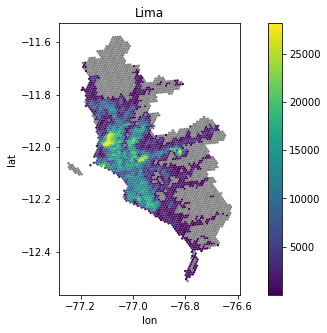

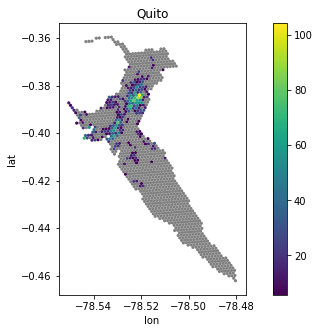

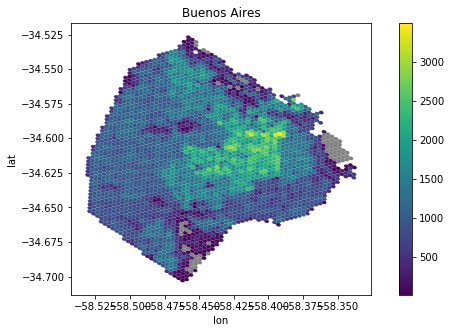

In [41]:
hex_lima.plot(column='population_2020', legend=True, cmap='viridis', figsize=(10,5), missing_kwds={'color':'grey'})
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Lima')
plt.show

hex_quito.plot(column='population_2020', legend=True, cmap='viridis', figsize=(10,5), missing_kwds={'color':'grey'})
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Quito')
plt.show

hex_ba.plot(column='population_2020', legend=True, cmap='viridis', figsize=(10,5), missing_kwds={'color':'grey'})
plt.xlabel('lon')
plt.ylabel('lat')
plt.title('Buenos Aires')
plt.show